# Kirjastot

In [1]:
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.response
from urllib.parse import urlparse
import datetime
import calendar
import matplotlib.dates as mdates
from urllib.parse import unquote
from sklearn import linear_model
import contextily as ctx
import geopandas
import geoplot
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# https://helsinki-openapi.nuuka.cloud/swagger/index.html
# https://www.youtube.com/watch?v=CnqdapOHh8g
# https://dev.hel.fi/paatokset/media/att/0c/0c1a38feb6f9a7b282efd0716c329508eff375cc.pdf

pd.set_option('display.max_colwidth', -1) # näytetään sarakeotsikot kokonaan
pd.set_option('display.max_rows', None) # näytetään kaikki rivitv

## Data

In [2]:
# Lista kaikista käyttötarkoituksista
industries = ['C%20kauppahalli','G%20monitoimitalo',
'F%20lasten%20p%C3%A4iv%C3%A4koti','G%20muu%20kokoontuminen',
'D%20toimisto','H%20ala-aste%20ja%20yl%C3%A4aste',
'H%20ammattiopetus%20ja%20-korkeak.','N%20maa-%20ja%20mets%C3%A4talous',
'N%20muu%20toimiala','K%20varasto',
'G%20kirjasto','C%20ravintola',
'F%20leikkipuisto','G%20museo',
'J%20tukikohta','C%20asuntola',
'C%20muu%20kauppa','A%20asuminen',
'F%20terveyskeskus','G%20liikuntatoimi',
'J%20muu%20tuotanto/teollisuus','H%20muu%20opetusrakennus',
'E%20liikenne','L%20v%C3%A4est%C3%B6nsuoja',
'C%20muu%20halli-%20ja%20ulkomyynti','F%20muu%20sosiaalihuollon%20laitos',
'F%20sairaala','F%20hoitokoti',
'L%20pelastusasema','H%20lukio', 'F%20vanhainkoti']

# haetaan sähkönkulutus ja lämmönkulutus omiin dataframeihin
dfelec = pd.DataFrame() # alustetaan dataframe, johon tulee sähkönkulutusdata
dfheat = pd.DataFrame() # alustetaan dataframe, johon tulee lämmönkulutusdata
dfinfo = pd.DataFrame() # alustetaan dataframe johon tulee kohteiden info
start = "2016-01-01"
end="2019-12-31"
for x in industries: # käydään läpi industries lista
    
    try:
        dfe = pd.read_json('https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Monthly/ListByProperty?Record=PurposeOfUse&SearchString=' + x + '&ReportingGroup=Electricity&StartTime=' + start + '&EndTime=' + end)
        dfh = pd.read_json('https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Monthly/ListByProperty?Record=PurposeOfUse&SearchString=' + x + '&ReportingGroup=Heat&StartTime=' + start + '&EndTime=' + end)
        nimi = x.replace("%20", " ").replace("%C3%A4", "ä").replace("%C3%B6", "ö") # muutetaan nimi luettavampaan muotoon
        dfe['heat'] = dfh['value']
        df = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=" + x + "&SearchFromRecord=purposeofUse")
        dfe = pd.merge(dfe, df)
        dfinfo = pd.concat([dfinfo,dfe])
    except urllib.error.HTTPError:
        print(x) # jos tulee ongelmia, tulostetaan kyseinen kohde

dfinfo.reset_index(inplace=True)
dfinfo.rename(columns={'value':'electricity'}, inplace=True)
dfinfo.drop(columns=['reportingGroup', 'unit', 'propertyName', 'propertyCode', 'reportingGroups', 'buildings', 'index'], inplace=True)

dfinfo.loc[dfinfo['totalArea'] == 0, 'totalArea'] = dfinfo['totalArea'].median()
dfinfo.loc[dfinfo['heatedArea'] == 0, 'heatedArea'] = dfinfo['totalArea'] * 0.7
dfinfo.loc[dfinfo['volume'] == 0, 'volume'] = dfinfo['totalArea'] * 3
dfinfo.loc[dfinfo['heatedArea'] > dfinfo['totalArea'], 'heatedArea'] = dfinfo['heatedArea'] / 10
dfinfo.loc[dfinfo['heatedArea'] < dfinfo['totalArea']/3, 'heatedArea'] = dfinfo['totalArea'] * 0.7


dfinfo['heat/m3'] = dfinfo['heat']/dfinfo['volume']
dfinfo['electricity/m3'] = dfinfo['electricity']/dfinfo['volume']
dfinfo['year'] = dfinfo['timestamp'].map(lambda x: x.year)
dfinfo['month'] = dfinfo['timestamp'].map(lambda x: x.month)
dfinfo['yearOfIntroduction'] = pd.to_datetime(dfinfo['yearOfIntroduction']).map(lambda x: x.year)

print('valmis')

C%20muu%20halli-%20ja%20ulkomyynti
valmis


## Scatterplot lämmityksen suhteesta sähkönkulutukseen

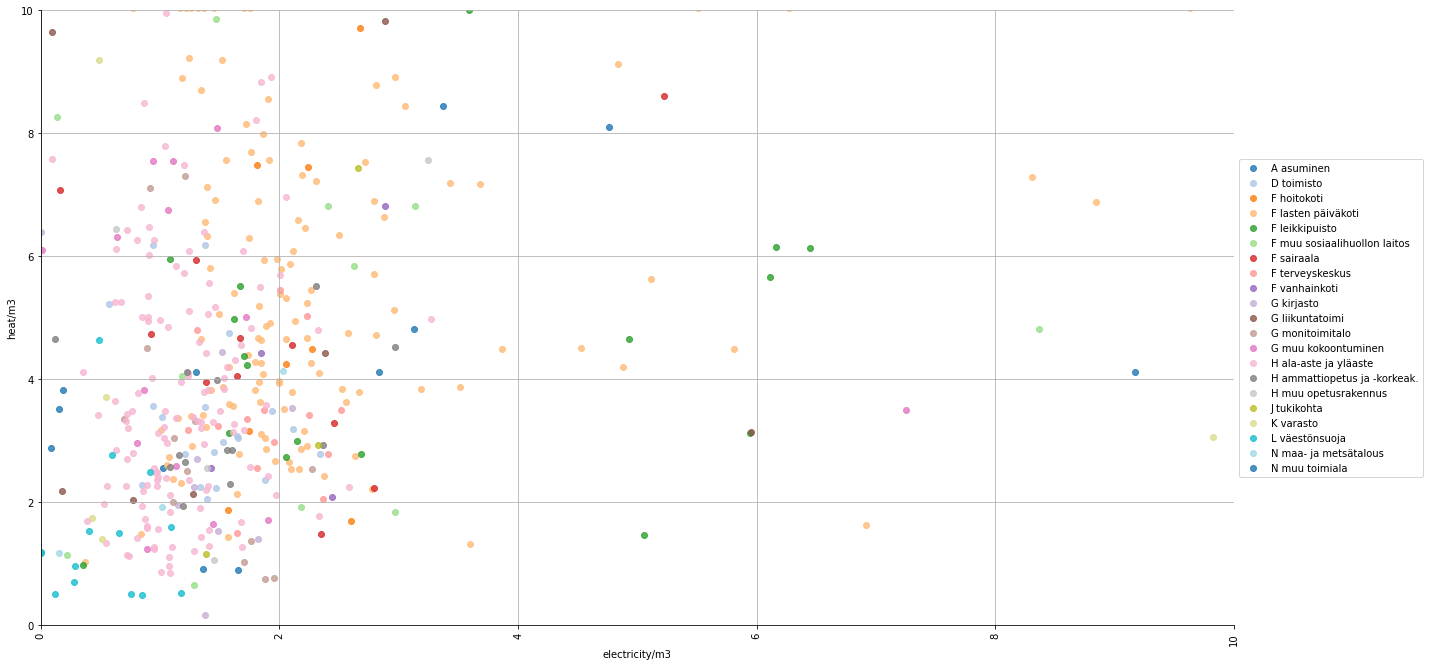

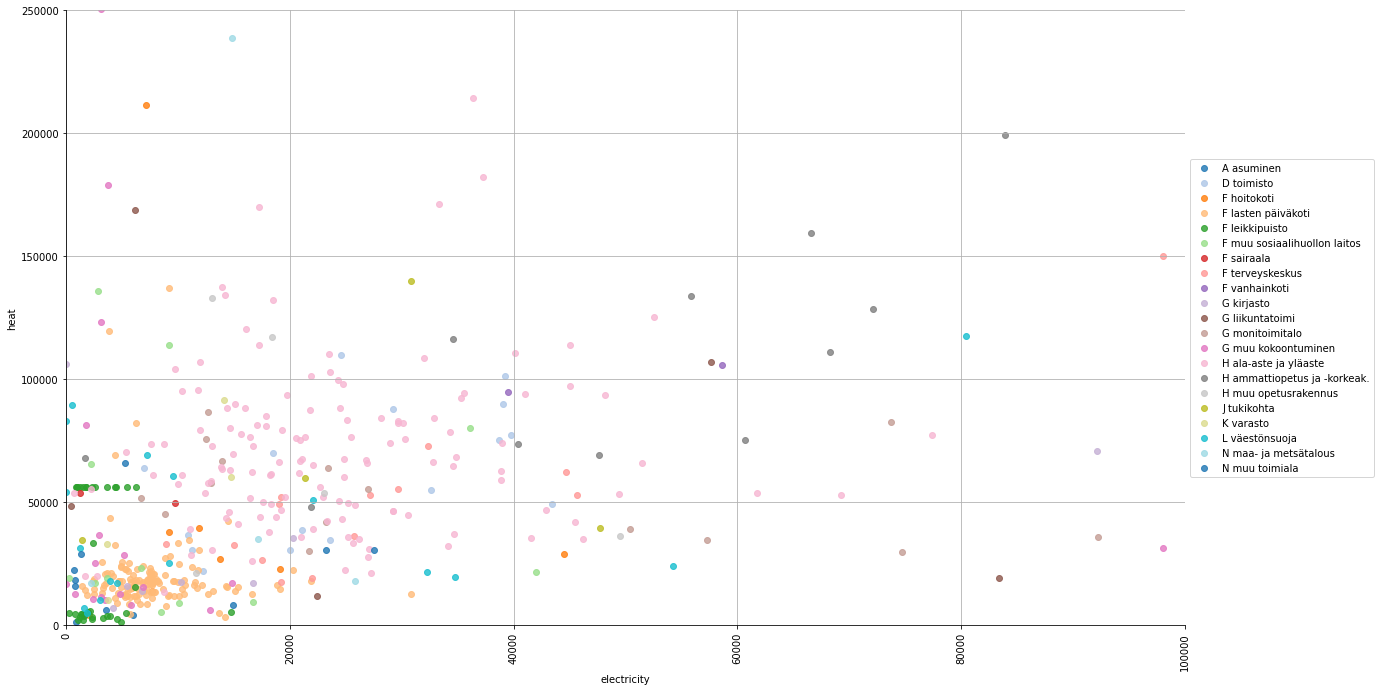

In [57]:
dfvuosi = dfinfo.groupby(['locationName', 'purposeOfUse', 'yearOfIntroduction', 'totalArea']).mean().reset_index()
dfvuosi = dfvuosi[dfvuosi['heat'] != 0]
dfvuosi = dfvuosi[dfvuosi['electricity'] != 0]
dfvuosi.sort_values('purposeOfUse', inplace=True)
#dfvuosi = dfvuosi[dfvuosi['buildingType'] != 'EducationalInstitution']
#dfvuosi = dfvuosi[dfvuosi['buildingType']!= 'Nursery']

sns.set_palette(sns.color_palette("hls", 20))
s = dfvuosi['purposeOfUse'].value_counts()
dfvuosi = dfvuosi[dfvuosi.isin(s.index[s >= 4]).values]

sns.lmplot(x="electricity/m3", y="heat/m3", data=dfvuosi, fit_reg=False, hue='purposeOfUse', legend=False, palette='tab20')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()
plt.xticks(rotation=90)

sns.lmplot(x="electricity", y="heat", data=dfvuosi, fit_reg=False, hue='purposeOfUse', legend=False, palette='tab20')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,0.25*10**6)
plt.xlim(0,0.1*10**6)
plt.grid()
plt.xticks(rotation=90)
plt.show()

# Klusterointi

In [42]:
dfcluster = dfvuosi.ffill()
km = KMeans(n_clusters=21)
km

KMeans(n_clusters=21)

In [50]:
y_predicted = km.fit_predict(dfcluster[['electricity', 'heat']])
#y_predicted

In [51]:
dfcluster['cluster'] = y_predicted

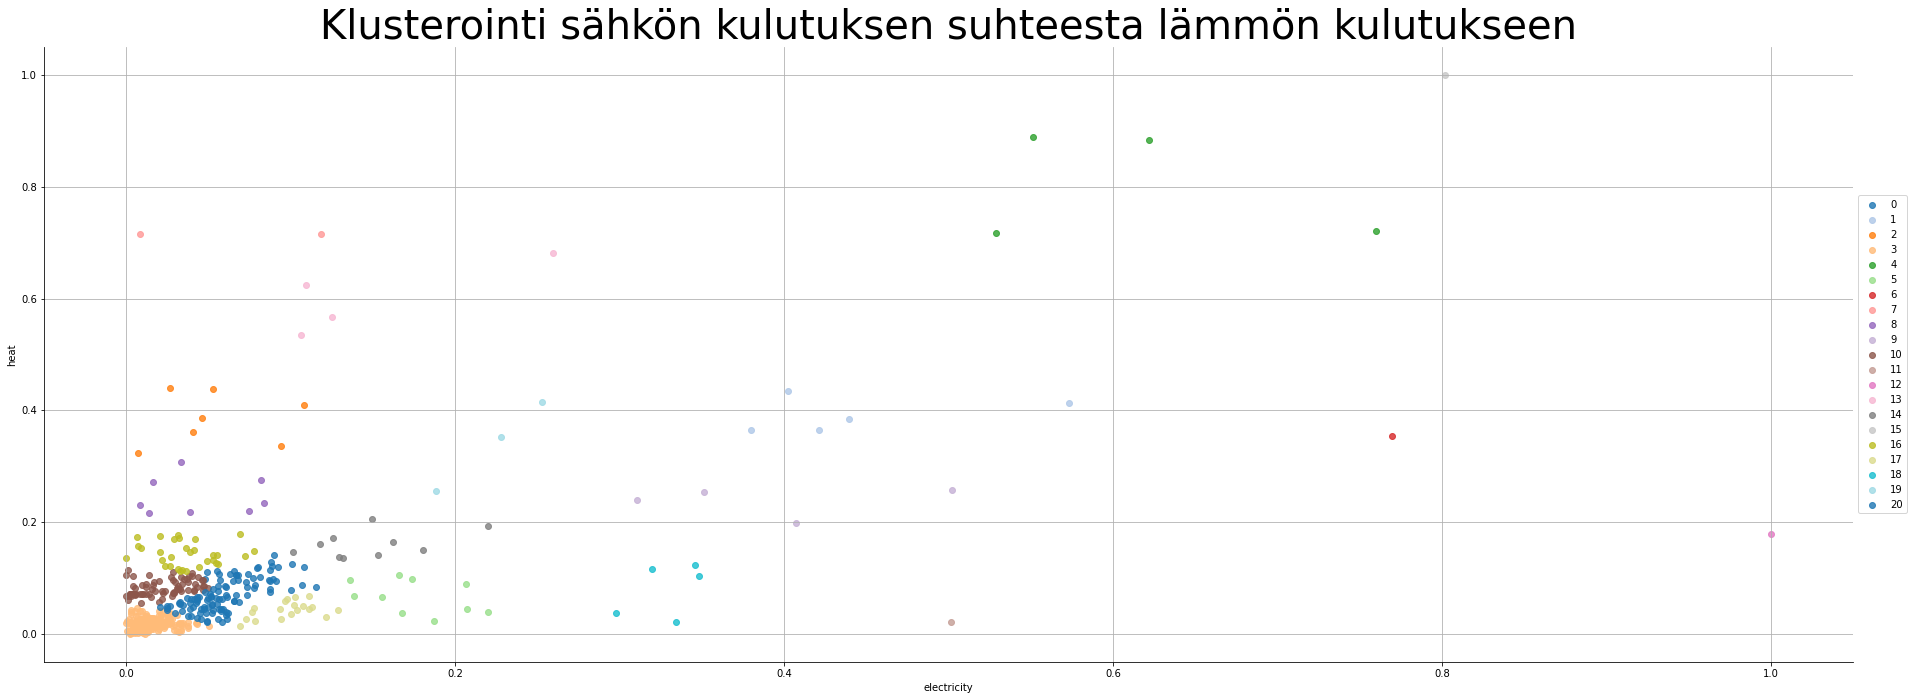

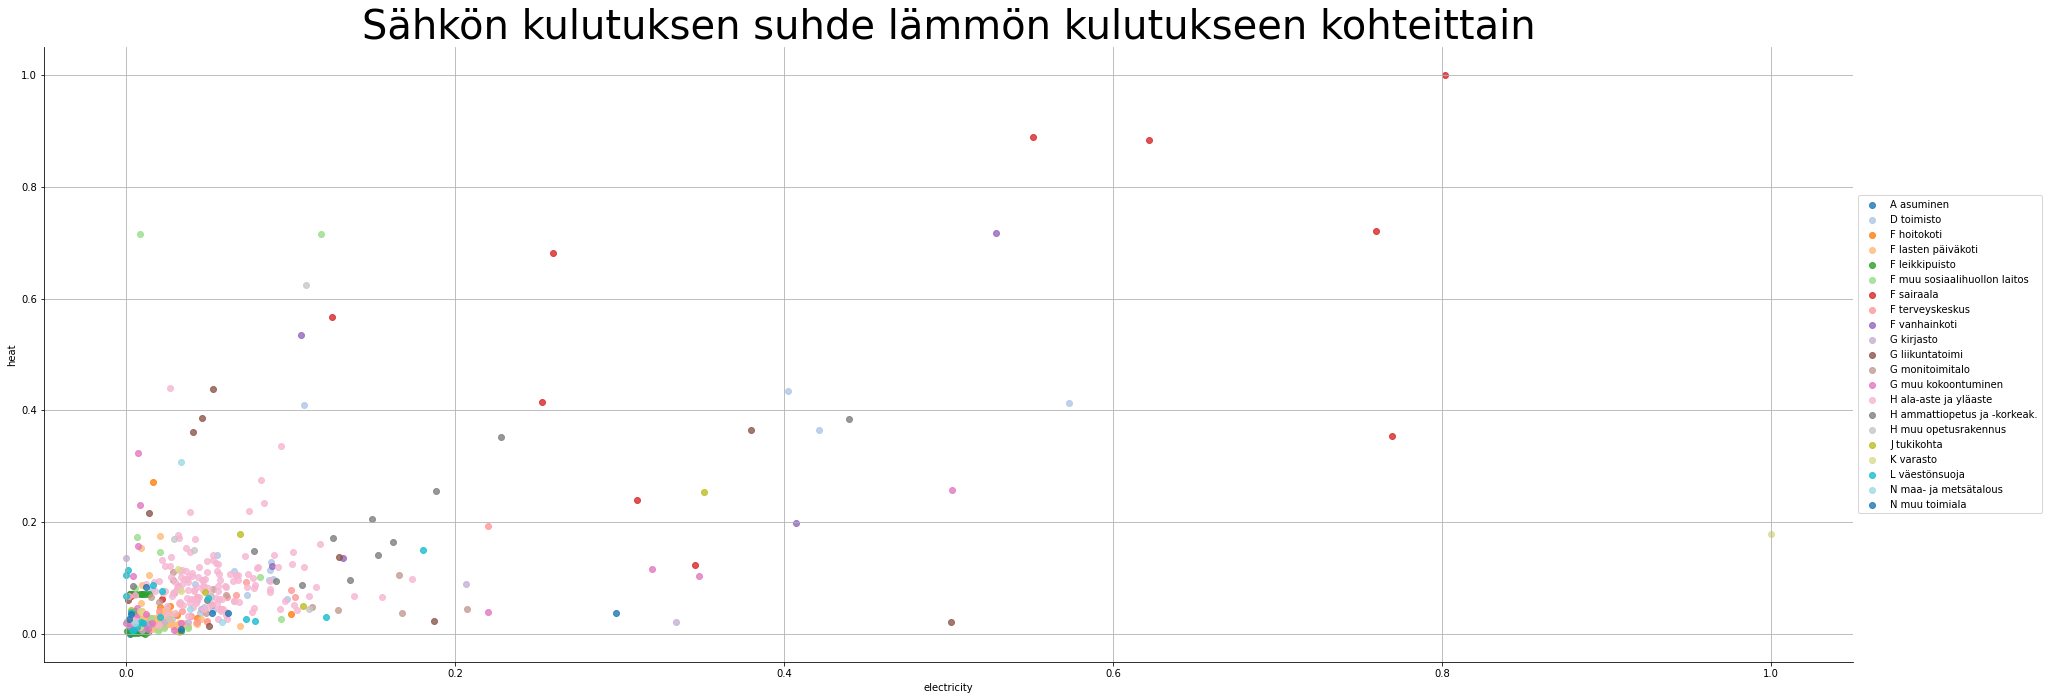

In [56]:
sns.lmplot(x="electricity", y="heat", data=dfcluster, fit_reg=False, hue='cluster', legend=False, palette='tab20')
fig = plt.gcf()
fig.set_size_inches(30,10)
#plt.yticks(np.arange(0, 300000, 20000))
plt.title("Klusterointi sähkön kulutuksen suhteesta lämmön kulutukseen", fontsize=40)
#plt.ylim(0,0.2*10**7)
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.lmplot(x="electricity", y="heat", data=dfcluster, fit_reg=False, hue='purposeOfUse', legend=False, palette='tab20')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.title("Sähkön kulutuksen suhde lämmön kulutukseen kohteittain", fontsize=40)
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))